In [163]:
import numpy as np
import pandas as pd
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns

In [164]:
"""
1. X (categorical) - x-axis spatial coordinate within the Montesinho park map: 1 to 9 
2. Y (categorical) - y-axis spatial coordinate within the Montesinho park map: 1 to 9 
3. month (categorical) - month of the year: 'jan' to 'dec' 
4. day (categorical) - day of the week: 'mon' to 'sun' 
5. FFMC (continuous) - FFMC (Fine Fuel Moisture Code) index from the FWI system: 18.7 to 96.20 
6. DMC (continuous) - DMC (Duff Moisture Code) index from the FWI system: 1.1 to 291.3 
7. DC (continuous) - DC (Drought Code) index from the FWI system: 7.9 to 860.6 
8. ISI (continuous) - ISI (Initial Spread Index) index from the FWI system: 0.0 to 56.10 
9. temp (continuous) - temperature in Celsius degrees: 2.2 to 33.30 
10. RH (contiuous) - relative humidity in %: 15.0 to 100 
11. wind (continuous) - wind speed in km/h: 0.40 to 9.40 
12. rain (continuous) - outside rain in mm/m2 : 0.0 to 6.4 
13. area (continuous) - the burned area of the forest (in ha): 0.00 to 1090.84 
(this output variable is very skewed towards 0.0, thus it may make 
sense to model with the logarithm transform).
"""

def size(x): 
    if x < 0.52:
        return 'small'
    elif 0.52<= x < 6.57: 
        return 'medium'
    return 'large'

forest_fires = pd.read_csv('forestfires.csv')

forest_fires['fire_size'] = forest_fires['area'].apply(size)

forest_fires.info()
# forest_fires.head(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
X            517 non-null int64
Y            517 non-null int64
month        517 non-null object
day          517 non-null object
FFMC         517 non-null float64
DMC          517 non-null float64
DC           517 non-null float64
ISI          517 non-null float64
temp         517 non-null float64
RH           517 non-null int64
wind         517 non-null float64
rain         517 non-null float64
area         517 non-null float64
fire_size    517 non-null object
dtypes: float64(8), int64(3), object(3)
memory usage: 56.6+ KB


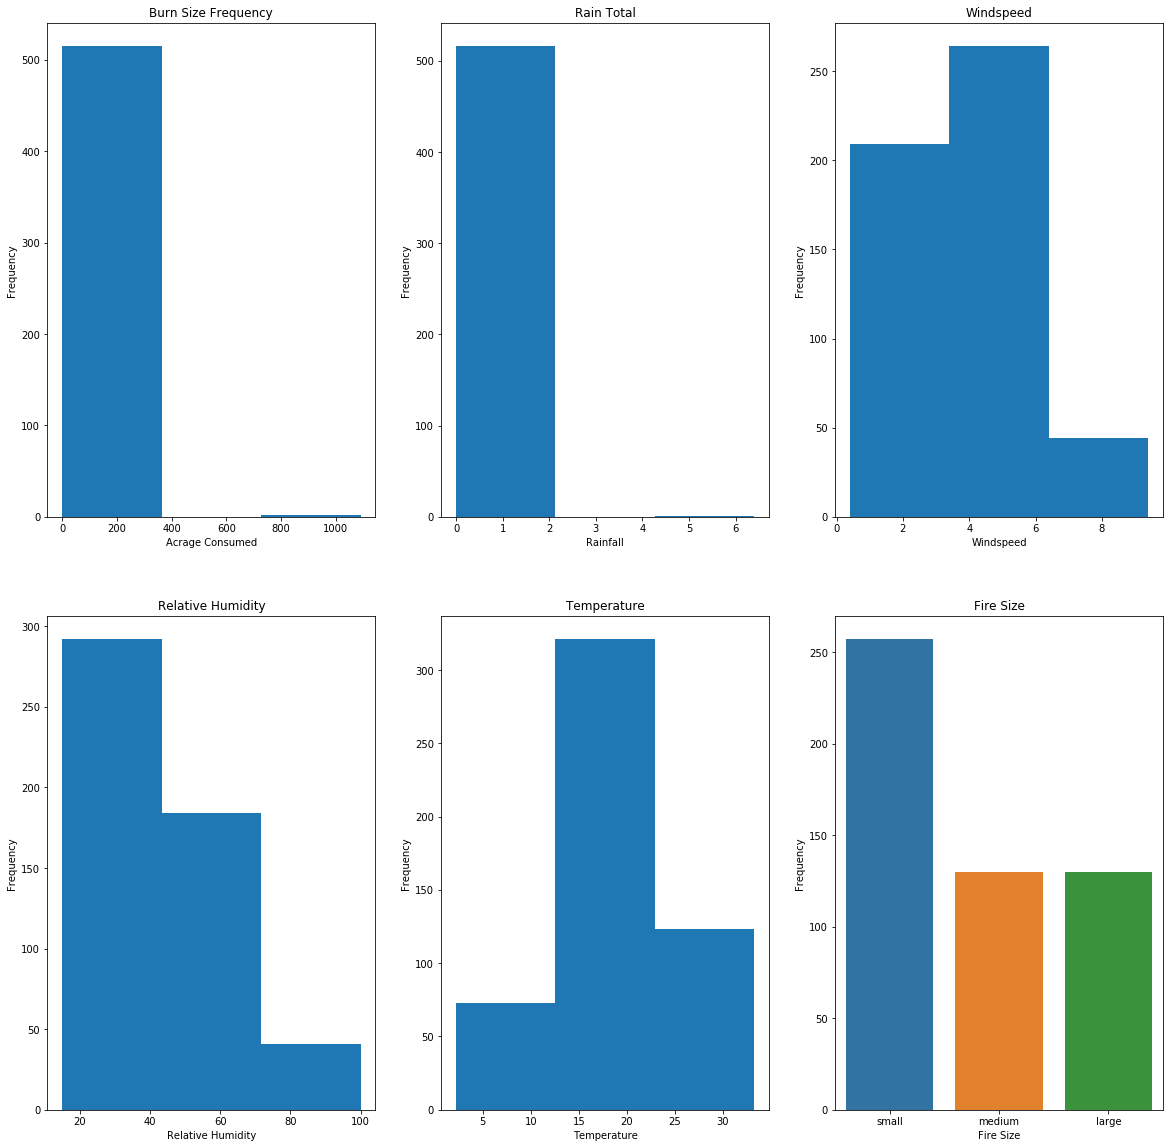

In [165]:
plt.figure(figsize=(20,20))

plt.subplot(2,3,1)
plt.hist(forest_fires['area'],bins=3)
# plt.ylim((0, forest_fires['area'].max()))
plt.xlabel('Acrage Consumed')
plt.ylabel('Frequency')
plt.title('Burn Size Frequency')

plt.subplot(2,3,2)
plt.hist(forest_fires['rain'],bins=3)
plt.xlabel('Rainfall')
plt.ylabel('Frequency')
plt.title('Rain Total')

plt.subplot(2,3,3)
plt.hist(forest_fires['wind'],bins=3)
plt.xlabel('Windspeed')
plt.ylabel('Frequency')
plt.title('Windspeed')

plt.subplot(2,3,4)
plt.hist(forest_fires['RH'],bins=3)
plt.xlabel('Relative Humidity')
plt.ylabel('Frequency')
plt.title('Relative Humidity')

plt.subplot(2,3,5)
plt.hist(forest_fires['temp'],bins=3)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature')

plt.subplot(2,3,6)
sns.countplot(x='fire_size', data=forest_fires)
plt.xlabel('Fire Size')
plt.ylabel('Frequency')
plt.title('Fire Size')

plt.show()

Burn Size Frequency: The most commonly sized fires are < 400 ha (hecares). 
Rain Total: Most fires occur when there has been < 3mm of rain.<br />
Windspeed: Most fires occur when windspeeds are between 4 and 6 km/h.<br />
Relative Humitity: Most fires occur when relative humidity (RH) < 70%.<br />
Burn Size: The majority of fires are small (< 0.52 ha).

Questions to Answer:
1. Can relationship between fire events and environmental conditions be established?
2. If so do certain environmental conditions have a demonstrable influence on fire events?
3. ???

In [166]:
min_burn_area = forest_fires['area'].min()
max_burn_area = forest_fires['area'].max()
range_burn_area = max_burn_area - min_burn_area

quartile_dict = forest_fires['area'].quantile([0.25,0.5,0.75]).to_dict()
iqr_burn_area = quartile_dict[0.75] - quartile_dict[0.25]
min_burn_area_fence = quartile_dict[0.25]
max_burn_area_fence = quartile_dict[0.75] + (iqr_burn_area*1.5)
mode_burn_area = forest_fires['area'].mode()
mode_fire_size = forest_fires['fire_size'].mode()
outlier_count = forest_fires[forest_fires['area']>max_burn_area_fence]['area'].count()
outlier_percentage = outlier_count/forest_fires['area'].count()

print(f"""
    In hectares:
    Min Burn Area: {min_burn_area},
    Max Burn Area: {max_burn_area},
    Mode Burn Area: {mode_burn_area[0]}, 
    Fire Size Mode: {mode_fire_size[0]}, 
    Burn Area Range: {range_burn_area}, 
    Q1: {quartile_dict[0.25]}, 
    Q2 (Median): {quartile_dict[0.50]}, 
    Q3: {quartile_dict[0.75]}, 
    IQR: {iqr_burn_area}, 
    Min Burn Area Fence: {min_burn_area_fence}, 
    Max Burn Area Fence: {max_burn_area_fence}, 
    Outlier Count: {outlier_count}
    Outlier Percentage: {outlier_percentage:.0%}
""")


    In hectares:
    Min Burn Area: 0.0,
    Max Burn Area: 1090.84,
    Mode Burn Area: 0.0, 
    Fire Size Mode: small, 
    Burn Area Range: 1090.84, 
    Q1: 0.0, 
    Q2 (Median): 0.52, 
    Q3: 6.57, 
    IQR: 6.57, 
    Min Burn Area Fence: 0.0, 
    Max Burn Area Fence: 16.425, 
    Outlier Count: 63
    Outlier Percentage: 12%



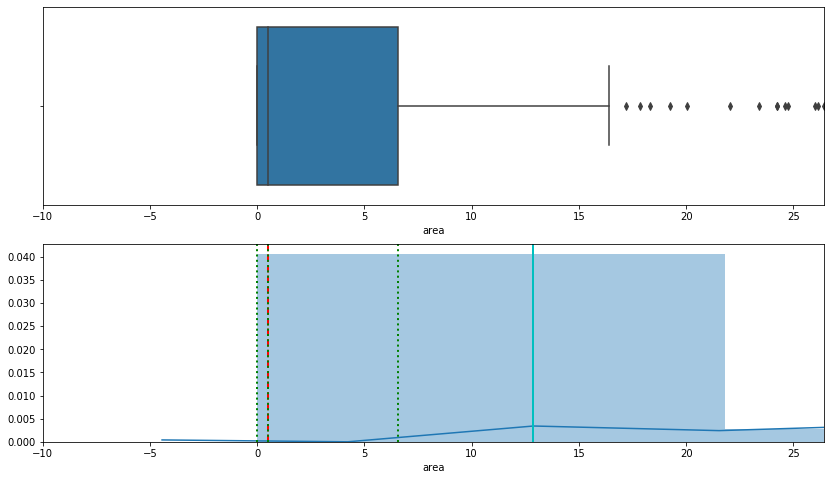

In [167]:
# Look for outliers in the burn area size
fig, axs = plt.subplots(nrows=2)
fig.set_size_inches(14,8)

plot1 = sns.boxplot(forest_fires['area'], ax=axs[0])
plot1.set(xlim=(min_burn_area_fence-10, max_burn_area_fence+10))

plot2 = sns.distplot(forest_fires['area'], ax=axs[1]) 
plot2.set(xlim=(min_burn_area_fence-10, max_burn_area_fence+10))

plt.axvline(quartile_dict[0.50], color='r', linestyle='dashed', linewidth=2)
plt.axvline(forest_fires['area'].mean(), color='c', linestyle='solid', linewidth=2)
for i,q in enumerate(forest_fires['area'].quantile([0.25,0.5,0.75])):
    plt.axvline(q, color='g', linestyle='dotted', linewidth=2)
    
plt.show()

In [168]:
# Remove burn area outliers
forest_fires2 = forest_fires[forest_fires['area']<16.425]

<h3>Evaluating the datasource</h3>
<p>
    <ul>
        <li>
            Unmodified the dataset is skewed because of the occurance of signifigant outliers.  The dataset needs to paired back to more accurately reflect normal state.
        </li>
    </ul>
</p>

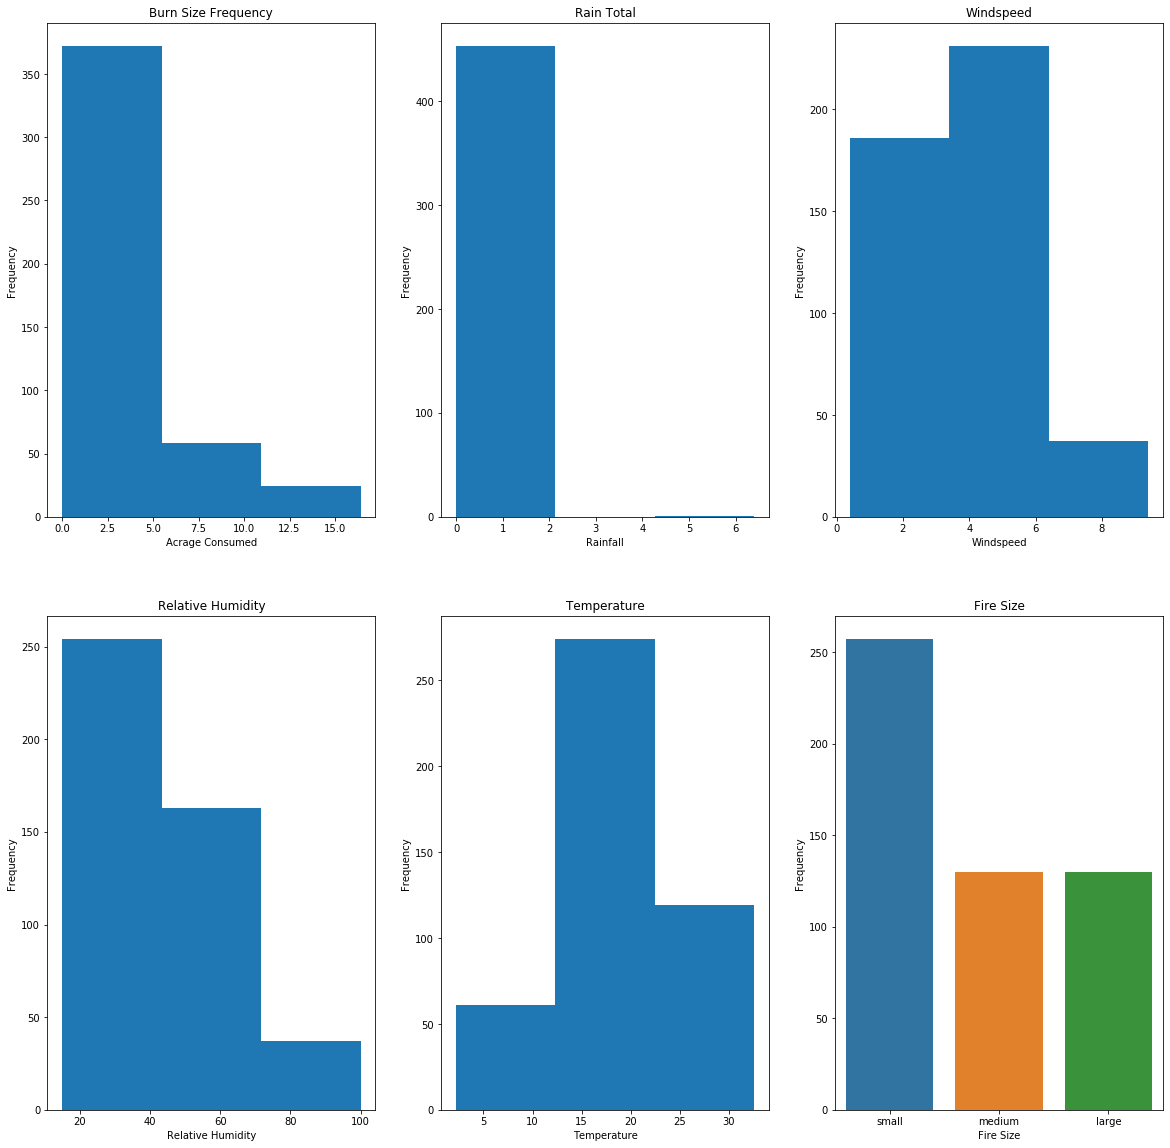

In [169]:
# Replot to look for changes
plt.figure(figsize=(20,20))

plt.subplot(2,3,1)
plt.hist(forest_fires2['area'],bins=3)
# plt.ylim((0, forest_fires['area'].max()))
plt.xlabel('Acrage Consumed')
plt.ylabel('Frequency')
plt.title('Burn Size Frequency')

plt.subplot(2,3,2)
plt.hist(forest_fires2['rain'],bins=3)
plt.xlabel('Rainfall')
plt.ylabel('Frequency')
plt.title('Rain Total')

plt.subplot(2,3,3)
plt.hist(forest_fires2['wind'],bins=3)
plt.xlabel('Windspeed')
plt.ylabel('Frequency')
plt.title('Windspeed')

plt.subplot(2,3,4)
plt.hist(forest_fires2['RH'],bins=3)
plt.xlabel('Relative Humidity')
plt.ylabel('Frequency')
plt.title('Relative Humidity')

plt.subplot(2,3,5)
plt.hist(forest_fires2['temp'],bins=3)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature')

plt.subplot(2,3,6)
sns.countplot(x='fire_size', data=forest_fires)
plt.xlabel('Fire Size')
plt.ylabel('Frequency')
plt.title('Fire Size')

plt.show()

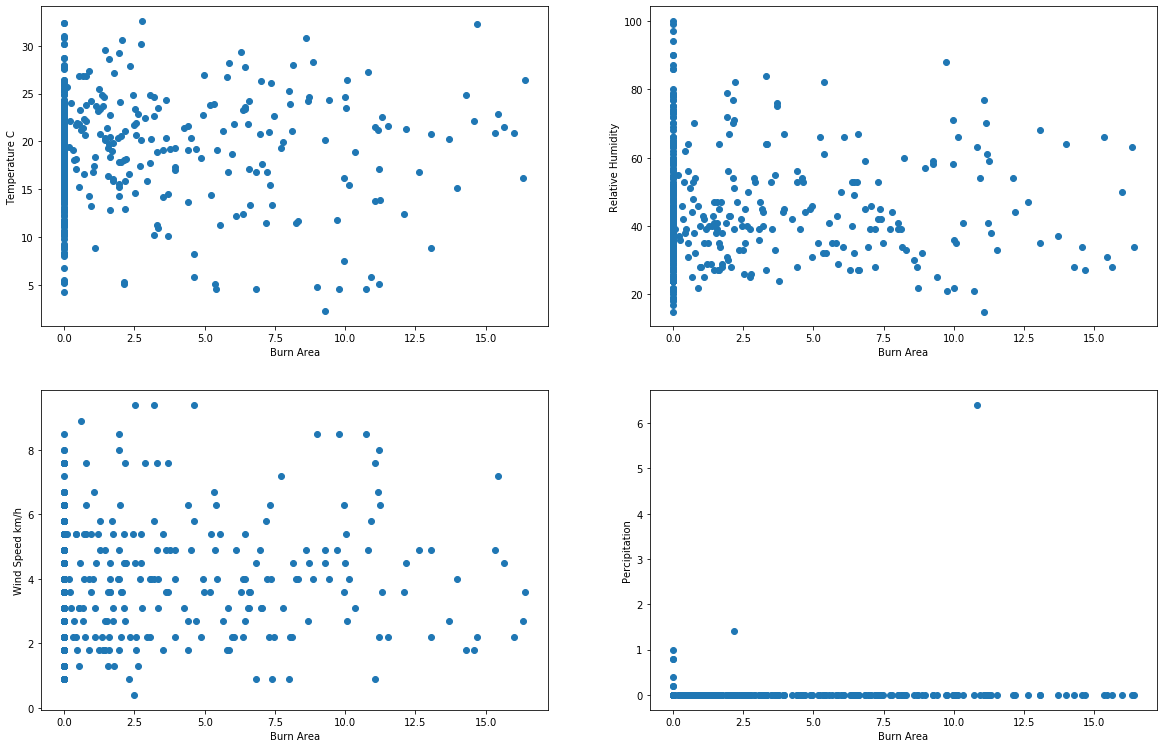

In [174]:
# Scatter plots to try to visualize relationships
plt.figure(figsize=(20,20))

plt.subplot(3,2,1)
plt.scatter(forest_fires2['area'], forest_fires2['temp'])
plt.xlabel('Burn Area')
plt.ylabel('Temperature C')

plt.subplot(3,2,2)
plt.scatter(forest_fires2['area'], forest_fires2['RH'])
plt.xlabel('Burn Area')
plt.ylabel('Relative Humidity')

plt.subplot(3,2,3)
plt.scatter(forest_fires2['area'], forest_fires2['wind'])
plt.xlabel('Burn Area')
plt.ylabel('Wind Speed km/h')

plt.subplot(3,2,4)
plt.scatter(forest_fires2['area'], forest_fires2['rain'])
plt.xlabel('Burn Area')
plt.ylabel('Percipitation')

plt.show()